In [1]:
import os 
os.environ["JAX_PLATFORM_NAME"] = "cpu"



import numpy as np
import h5py 
from train_pybird_emulators.emu_utils.k_arrays import k_emu, k_pybird
from train_pybird_emulators.emu_utils import integrated_model
from train_pybird_emulators.emu_utils import emu_utils
import jax.numpy as jnp
import matplotlib.pyplot as plt 
from pybird.correlator import Correlator


loading loop matrices!


2024-10-16 06:08:19.698038: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-16 06:08:19.710738: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-16 06:08:19.714416: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-16 06:08:21.052569: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".80"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

In [3]:
fn = "/cluster/scratch/areeves/pybird_training_data_pybird_gc/total_data.h5"
piece_name = "Ploopl"
model_name = "ploopl_mono_80knots_newbank_gc_log"
mono = True
quad_hex=False
quad_alone=False
hex_alone=False
n_test=1000
mask_high_k = False

In [4]:

x_train, y_train = emu_utils.get_training_data_from_hdf5(
    fn,
    piece_name,
    n_test,
    mono=mono,
    quad_hex=quad_hex,
    quad_alone=quad_alone,
    hex_alone=hex_alone,
    mask_high_k=False,
)
print(np.where(y_train[0]==0))

if mask_high_k:
    if k_emu.shape[0] != y_train.shape[1]:
        num_patterns = y_train.shape[1] // k_pybird.shape[0]
        single_mask = np.array(
            [True] * k_emu.shape[0]
            + [False] * (k_pybird.shape[0] - k_emu.shape[0])
        )

        # Repeat the mask for num_patterns times
        full_mask = np.tile(single_mask, num_patterns)
        # Apply the mask to remove the high k parts of the array
        y_train = y_train[:, full_mask]
        y_train, x_train = emu_utils.remove_nan_rows_from_both_arrays(
            y_train, x_train
        )
print(np.where(y_train[0]==0))

# Filter out bad indices
if piece_name is not None:
    print(f"filtering out bad indices for piece {piece_name}")

    condition_1 = np.any(x_train[:, :-2] > 0, axis=1)
    condition_2 = x_train[:, -1] < 0
    condition_3 = x_train[:, -2] < 0
    condition_4 = x_train[:, -2] > 20000

    gradients_first_5 = np.diff(x_train[:, :6], axis=1)  # Shape: (num_samples, 5)
    negative_gradients = gradients_first_5 < 0  # Shape: (num_samples, 5)
    condition_5 = np.any(negative_gradients, axis=1)

    bad_inds = np.where(condition_1 | condition_2 | condition_3 | condition_4 | condition_5)[0]

    if piece_name.startswith("I"):
        print("training IR piece... going to filter out large gradients")
        # Calculate the absolute gradients along each row
        gradients = np.abs(np.diff(y_train, axis=1))

        gradient_threshold = np.quantile(
            gradients, 0.70
        )  # top 30% of gradients

        # spikes typically happen around high k
        spike_positions = np.arange(
            k_emu.shape[0] - 7, gradients.shape[1], k_emu.shape[0]
        )  # Adjust for 0-index and diff output size

        # Condition to identify rows with gradient spikes at specific positions
        condition_4 = np.any(
            gradients[:, spike_positions] > gradient_threshold, axis=1
        )

        condition_5 = x_train[:, -2] > 20000

        bad_inds = np.where(
            condition_1 | condition_2 | condition_3 | condition_4 | condition_5
        )[0]

    print(f"removing {len(bad_inds)} bad indices")
    x_train = np.delete(x_train, bad_inds, axis=0)
    y_train = np.delete(y_train, bad_inds, axis=0)

# # Are there places where all the columns in the data are zero?
zero_columns = np.where(np.sum(np.abs(y_train), axis=0) == 0)[0]

# if zero_columns is not None and zero_columns.shape[0] > 0:
#     print(f"removing zero columns for piece {piece_name}")
#     # remove and save zero columns indices
#     y_train = np.delete(y_train, zero_columns, axis=1)
#     print("zero columns", zero_columns)    

24-10-16 06:08:28 train_pybi INF   total number of available training points: 2394400 
24-10-16 06:08:28 train_pybi INF   Available keys in the file: <KeysViewHDF5 ['IRPs11', 'IRPsct', 'IRPsloop', 'P11l', 'Pctl', 'Ploopl', 'params']> 
24-10-16 06:08:28 train_pybi INF   Using monopole data for Ploopl 
where are zeros?
(array([   0,   77,  154,  231,  308,  385,  462,  539,  616,  693,  770,
        847,  924, 1001, 1078, 1155, 1232, 1309, 1386, 1463, 1540, 1617,
       1694, 1771, 1848, 1925, 2002, 2079, 2156, 2233, 2310, 2387, 2464,
       2541, 2618, 2695, 2772, 2849, 2926, 3003, 3080, 3157, 3234, 3311,
       3388, 3465, 3542, 3619, 3696, 3773, 3850, 3927, 4004, 4081, 4158,
       4235, 4312, 4389, 4390, 4391, 4392, 4393, 4394, 4395, 4396, 4466,
       4467, 4468, 4469, 4470, 4471, 4472, 4473, 4543, 4620, 4697, 4774,
       4775, 4776, 4777, 4778, 4779, 4780, 4781, 4851, 4928, 4929, 4930,
       4931, 4932, 4933, 4934, 4935, 5005, 5006, 5007, 5008, 5009, 5010,
       5011, 5012, 5082

In [5]:
testing_spectra = y_train

In [6]:
testing_spectra[0]

array([ 0.0000000e+00,  5.3813086e-11,  4.5322093e-10, ...,
       -5.0131489e-06, -5.0601175e-06, -5.1049628e-06], dtype=float32)

In [7]:
np.where(testing_spectra[0]==0)

(array([   0,   77,  154,  231,  308,  385,  462,  539,  616,  693,  770,
         847,  924, 1001, 1078, 1155, 1232, 1309, 1386, 1463, 1540, 1617,
        1694, 1771, 1848, 1925, 2002, 2079, 2156, 2233, 2310, 2387, 2464,
        2541, 2618]),)

In [8]:
from pybird import config 
config.set_jax_enabled(True) # Enable JAX by setting the config Class

from pybird import integrated_model_jax
test_model = integrated_model_jax.IntegratedModel(None,None,None,None)
test_model.restore(f"/cluster/work/refregier/alexree/local_packages/train_pybird_emulators/src/train_pybird_emulators/data/saved_models/{model_name}_model.h5")

using jax
LOG PREPROCESS True


In [9]:
predicted_testing_spectra = test_model.predict(x_train)

(2695,)
(2695,)
(2695,)
(2695,)
(2695,)
(2695,)
(2695,)
(2695,)
(2695,)
(2695,)
(2695,)
(2695,)
(2695,)
(2695,)
(2695,)
(2695,)
(2695,)
(2695,)
(2695,)
(2695,)
(2695,)
(2695,)
(2695,)
(2695,)
(2695,)


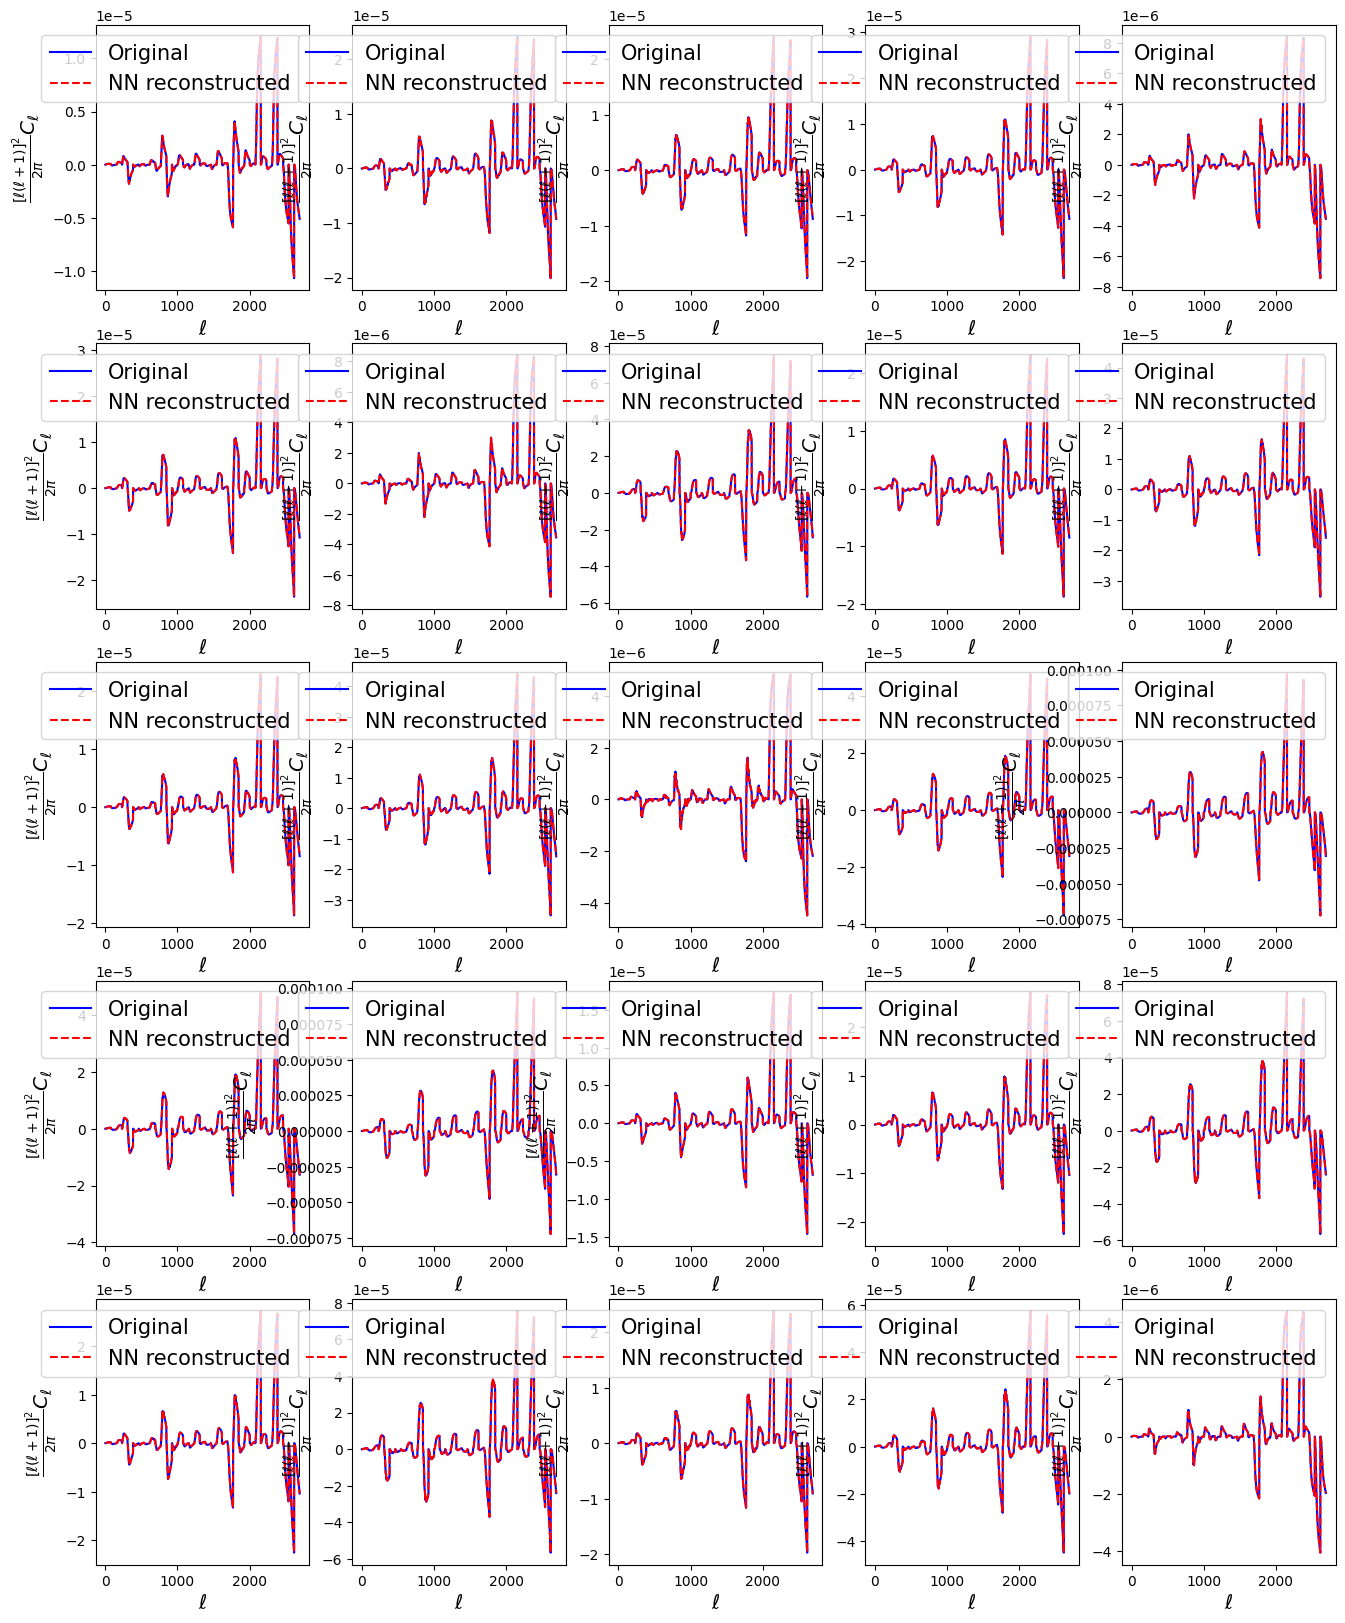

In [10]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(16,20))
for j in range(5):
    for i in range(5):
        pred = predicted_testing_spectra[i+j*3]
        true = testing_spectra[i+j*3]
        print(true.shape)
        ell_range = np.arange(true.shape[0])
        ax[j, i].plot(ell_range, true, 'blue', label = 'Original')
        ax[j, i].plot(ell_range, pred, 'red', label = 'NN reconstructed', linestyle='--')
        ax[j, i].set_xlabel('$\ell$', fontsize='x-large')
        ax[j, i].set_ylabel('$\\frac{[\ell(\ell+1)]^2}{2 \pi} C_\ell$', fontsize='x-large')
        ax[j, i].legend(fontsize=15)
plt.savefig('examples_reconstruction_PP.pdf')

In [11]:
testing_spectra.shape 

(368, 2695)

In [12]:
(1-np.median(np.abs((testing_spectra[:, ~zero_columns]-predicted_testing_spectra[:, ~zero_columns])/testing_spectra[:, ~zero_columns])))*100

99.81146671358071

In [13]:
zero_columns

array([   0,   77,  154,  231,  308,  385,  462,  539,  616,  693,  770,
        847,  924, 1001, 1078, 1155, 1232, 1309, 1386, 1463, 1540, 1617,
       1694, 1771, 1848, 1925, 2002, 2079, 2156, 2233, 2310, 2387, 2464,
       2541, 2618])

In [14]:
knots = np.load("/cluster/work/refregier/alexree/local_packages/train_pybird_emulators/src/train_pybird_emulators/data/knots_data/final_knots_80.npy")

In [15]:
knots 

array([1.00000000e-04, 1.46002162e-04, 2.13166312e-04, 3.11227423e-04,
       4.54398764e-04, 6.63432018e-04, 9.68625086e-04, 1.41421356e-03,
       2.06478237e-03, 3.01462689e-03, 4.40142042e-03, 6.42616895e-03,
       9.38234557e-03, 1.36984273e-02, 2.00000000e-02, 2.10000000e-02,
       2.39166870e-02, 2.72384723e-02, 3.10216198e-02, 3.53302082e-02,
       4.02372158e-02, 4.58257569e-02, 5.21904898e-02, 5.94392195e-02,
       6.76947243e-02, 7.70968349e-02, 8.78048033e-02, 1.00000000e-01,
       1.10000000e-01, 1.14064792e-01, 1.18279789e-01, 1.22650542e-01,
       1.27182805e-01, 1.31882548e-01, 1.36755958e-01, 1.41809454e-01,
       1.47049690e-01, 1.52483567e-01, 1.58118240e-01, 1.63961129e-01,
       1.70019928e-01, 1.76302616e-01, 1.82817466e-01, 1.89573057e-01,
       1.96578285e-01, 2.03842375e-01, 2.11374892e-01, 2.19185756e-01,
       2.27285252e-01, 2.35684046e-01, 2.44393197e-01, 2.53424175e-01,
       2.62788871e-01, 2.72499618e-01, 2.82569203e-01, 2.93010886e-01,
      

In [16]:
knots2 = np.load("/cluster/work/refregier/alexree/local_packages/pybird_emu/data/emu/knots.npy")

In [17]:
knots2/knots 

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [18]:
zero_columns 

array([   0,   77,  154,  231,  308,  385,  462,  539,  616,  693,  770,
        847,  924, 1001, 1078, 1155, 1232, 1309, 1386, 1463, 1540, 1617,
       1694, 1771, 1848, 1925, 2002, 2079, 2156, 2233, 2310, 2387, 2464,
       2541, 2618])

In [19]:
N = Correlator()
# Set up pybird in time unspecified mode for the computation of the pybird pieces training data
N.set(
    {
        "output": "bPk",
        "multipole": 3,
        "kmax": 0.6,
        "fftaccboost": 2,
        "with_resum": True,
        "with_exact_time": True,
        "with_time": False,  # time unspecified
        "km": 1.0,
        "kr": 1.0,
        "nd": 3e-4,
        "eft_basis": "eftoflss",
        "with_stoch": True,
    }
)

# internal pybird k-array
k_pybird = N.co.k

loading loop matrices!


In [20]:
k_pybird.shape 

(97,)